### Spain gross income distribution per person

In this notebook I will develop on an application of the lognormal distribution.

  Data of gross income per person in euros for Spain is fitted to a [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). The distribution of income has been succesfully modeled in economics for up to approximately 95% of the population of a country using a lognormal model. Data downloaded from Spain's [National Institute of Statistics](https://www.ine.es/index.htm) (INE - Instituto Nacional de Estadística) will be used to estimate the paremeters of the distribution.
  
  In order to understand the method used to derive the parameters of the distribution one should know what is:
  - Normal distribution.
  - Standard normal distribution.
  - Lognormal distribution.
  - Quantile.
  - Logarithms and exponents.
  - Basic optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

In [2]:
# Origin: https://www.ine.es/buscar/searchResults.do?searchString=%22Distribuci%C3%B3n+salarial%22&searchType=DEF_SEARCH&startat=0&L=0
# Data uploaded to kaggle for ease of access: 
# https://www.kaggle.com/jtljtl/spain-salary-distribution
df = pd.read_csv("spain_salary_distribution.csv",sep=';',encoding='iso-8859-1')

# Convert attribute "Total" from Object data type to float
df["Total"] = df["Total"].apply(lambda x: float(x.replace('.','').replace(',','.')))

# Map statistics in words to numbers
qmap = {"Cuartil superior" : 0.75,
        "Cuartil inferior" : 0.25,
        "Mediana" : 0.5,
        "Percentil 90" : 0.9,
        "Percentil 10" : 0.1,
        "Media" : np.nan}

df["Percentil"] = df["Medidas y percentiles"].apply(lambda s: qmap.get(s))

We are given statistics about the gross income in euros (Total), per person for Spain. We have in "Medias y percentiles":
- The 10th percentile (Percentil 10).
- The lower quartile (Cuartil inferior).
- The median (Mediana).
- The mean (Media).
- The upper quartile (Cuartil superior).
- The 90th percentile (Percentil 90).

These statistics are seggregated by:

- Gender (Sexo).
- Year (Periodo).
- State (Comunidades autónomas).

In this notebook I will just explore total national incomes, but the analysis could be extended much futher, for example to gender, year and state.

In [12]:
df.sample(20)

,Comunidades autónomas,Sexo,Medidas y percentiles,Periodo,Total,Percentil
820,"Balears, Illes",Mujeres,Cuartil superior,2017,24565.83,0.75
2182,Galicia,Ambos sexos,Cuartil inferior,2015,13199.46,0.25
1938,Comunitat Valenciana,Hombres,Percentil 10,2009,11080.21,0.10
2347,"Madrid, Comunidad de",Ambos sexos,Media,2010,25988.95,NaN
2209,Galicia,Ambos sexos,Cuartil superior,2008,23001.97,0.75
1134,Cantabria,Ambos sexos,Percentil 90,2013,35467.68,0.90
1160,Cantabria,Mujeres,Cuartil inferior,2017,11223.96,0.25
468,Aragón,Mujeres,Cuartil superior,2009,22993.08,0.75
2276,Galicia,Mujeres,Percentil 90,2011,30532.17,0.90
2101,Extremadura,Hombres,Media,2016,21554.75,NaN


In [10]:
filter_df = lambda c,s,m: (df.iloc[:,0] == c) & (df.iloc[:,1] == s) & (df.iloc[:,2] == m)
df_filter = filter_df('Total Nacional','Ambos sexos','Mediana')
df_filter2 = filter_df('Total Nacional','Ambos sexos','Media')
df_filter3 = filter_df('Total Nacional','Ambos sexos','Cuartil inferior')
df_filter4 = filter_df('Total Nacional','Ambos sexos','Cuartil superior')
df_filter5 = filter_df('Total Nacional','Ambos sexos','Percentil 90')
df_filter6 = filter_df('Total Nacional','Ambos sexos','Percentil 10')

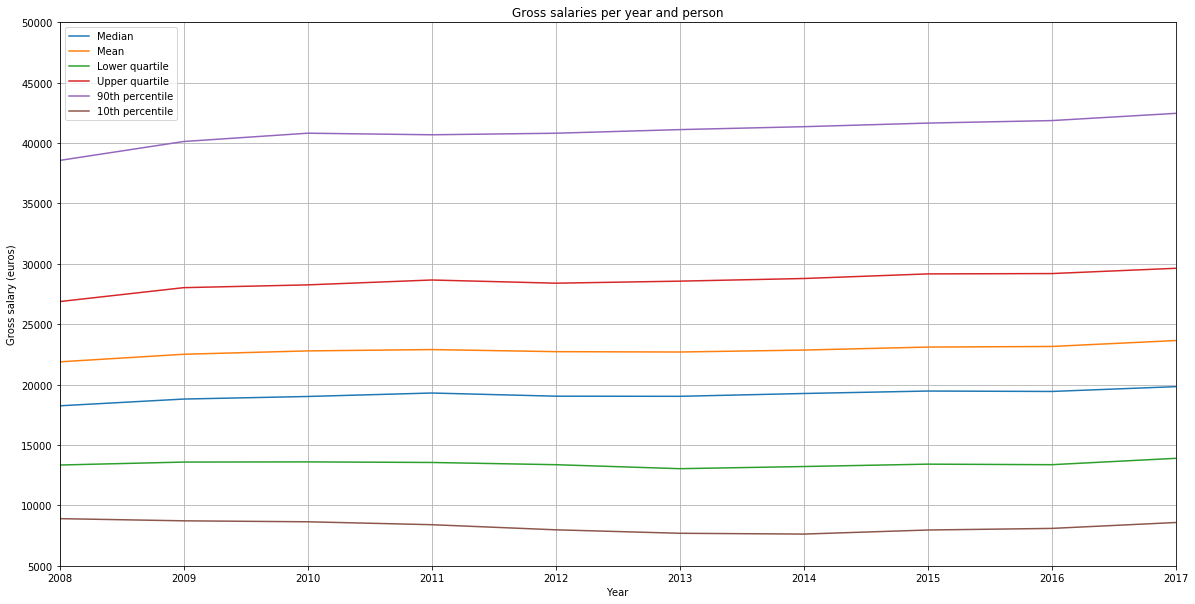

In [11]:
fig = plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_xlim([2008,2017])
axes.set_ylim([5000,50000])

plt.plot(df[df_filter]["Periodo"],df[df_filter]["Total"],label='Median')
plt.plot(df[df_filter2]["Periodo"],df[df_filter2]["Total"],label="Mean")
plt.plot(df[df_filter3]["Periodo"],df[df_filter3]["Total"],label='Lower quartile')
plt.plot(df[df_filter4]["Periodo"],df[df_filter4]["Total"],label='Upper quartile')
plt.plot(df[df_filter5]["Periodo"],df[df_filter5]["Total"],label='90th percentile')
plt.plot(df[df_filter6]["Periodo"],df[df_filter6]["Total"],label='10th percentile')
plt.title('Gross salaries per year and person')
plt.legend(loc='upper left')
plt.grid()
plt.ylabel('Gross salary (euros)')
plt.xlabel('Year')
plt.show()

### Fitting data to a lognormal distribution


$ X \sim Lognorm(\mu, \sigma^2) $

I suppose that the income is distributed lognormally between the 10th and 90th percentiles. To find the parameters of the distribution, I use the analytic formula for the median of the distribution:

$$ median = e^\mu \implies \mu = log(median) \qquad (1)$$

For the standard deviation ($\sigma$), we know since it is lognormal distribution that:

$$ q = P(X \leq x_q) = \Phi\left(Z \leq \frac{log(x_q) - \mu}{\sigma}\right) \qquad (2)$$

The quantiles given and the logarithm of their respective values follow a normal distribution, so we can standardize the income random variable and find the corresponding values of the standard normal random variable that corresponds to those quantiles.

In [15]:
quantiles = [0.1,0.25,0.5,0.75,0.9]
z = stats.norm.ppf(quantiles)
z

array([-1.28155157, -0.67448975,  0.        ,  0.67448975,  1.28155157])

Now associate values of the income to those quantiles, which we can do visually by looking at the plot above so, approximately:


In [16]:
xq = [9000,14000,20000,30000,42000]

Since we know $\mu$ by (1), $X_q$ and $q$ by data, and $Z$ by calculation, we can compute sigma by minimizing the squared error in (2):

$$ Error(\sigma) = \sum_i^n \left(z_i - \frac{log(x_{qi}) - \mu}{\sigma} \right)^2 \qquad (3)$$

In [41]:
# scipy parametrization. mu calculated as in (1)
loc = np.log(20000) # (1): mu = log(median)

# Define the error function as in (3)
error = lambda sigma: sum((zi - (np.log(xqi)-loc)/sigma)**2 for zi,xqi in zip(z,xq))

# Initial guess as in (4)
sigma = lambda mean, mu: (2*(np.log(mean)-mu))**0.5
x0 = sigma(30000,loc)

# Minimize it. res.x contains the value of the parameter
res = minimize(error, x0=x0, method='Nelder-Mead', tol=1e-6)
res.x

array([0.59468505])

$x0$ is an estimate of the parameter being minimized. I set it to one by using the formula:

$$ mean = exp\left(\mu + \frac{\sigma^2}{2}\right) \implies \sigma^2 = 2log(mean) - 2\mu \qquad (4)$$

Since we know the mean (data) and $\mu$ we can use (4) to find a educated guess of $\sigma$:

In [40]:
sigma(30000,np.log(20000))

0.9005166385005504

Which is close to the optimized value of 0.594, and thus is a good initial guess for an starting point.

This is only one of the many possible ways of estimating the parameters of the distribution. I used this method since we were given quantiles and not the sampled data. So the idea is to fit the quantiles to the CDF of the lognormal distribution.

In [21]:
 t = pd.concat([df[df_filter]["Total"],
          df[df_filter2]["Total"],
          df[df_filter3]["Total"],
          df[df_filter4]["Total"],
          df[df_filter5]["Total"],
          df[df_filter6]["Total"]])

# Generate samples from the calculated distribution to make plots
q = np.arange(0.1,0.91,0.01)
x = stats.lognorm.ppf(q,s=res.x,scale=20000)

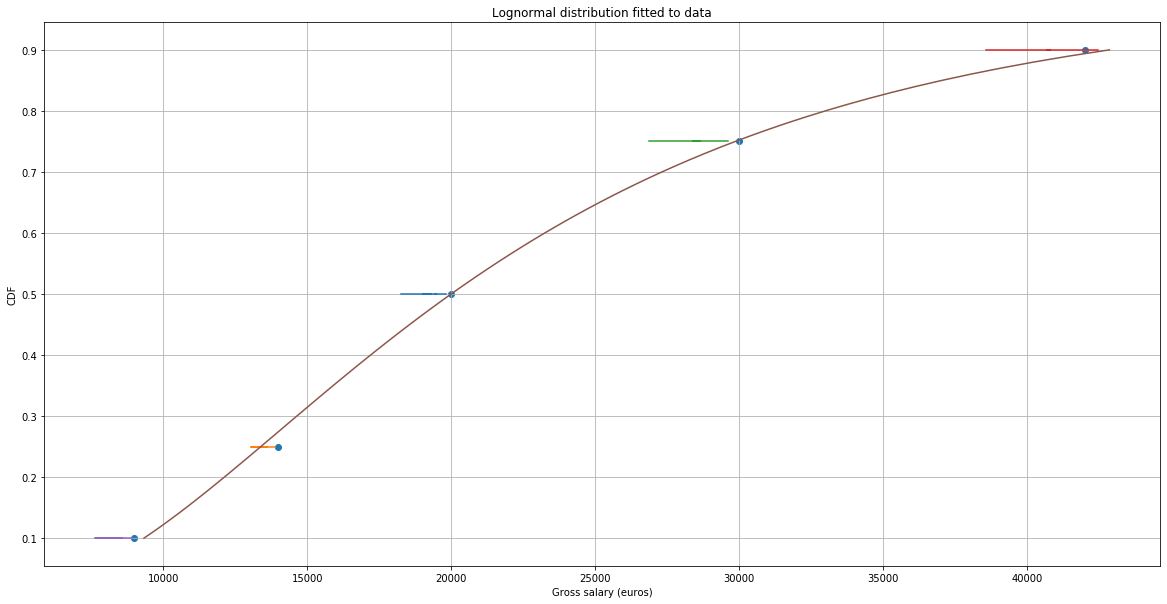

In [27]:
fig = plt.figure(figsize=(20,10))
axes = plt.gca()

plt.plot(df[df_filter]["Total"],df[df_filter]["Percentil"])
plt.plot(df[df_filter3]["Total"],df[df_filter3]["Percentil"])
plt.plot(df[df_filter4]["Total"],df[df_filter4]["Percentil"])
plt.plot(df[df_filter5]["Total"],df[df_filter5]["Percentil"])
plt.plot(df[df_filter6]["Total"],df[df_filter6]["Percentil"])
plt.scatter(xq,quantiles)
plt.plot(x,q)

plt.title('Lognormal distribution fitted to data')
plt.grid()
plt.xlabel('Gross salary (euros)')
plt.ylabel('CDF')
plt.show()

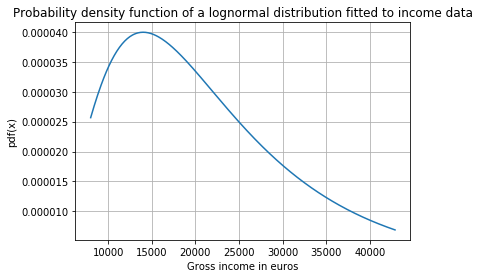

In [381]:
xinc = np.arange(8000,43000,100)
plt.plot(xinc, stats.lognorm.pdf(xinc,s=res.x,scale=20000))
plt.xlabel('Gross income in euros')
plt.ylabel('pdf(x)')
plt.grid()
plt.title('Probability density function of a lognormal distribution fitted to income data')
plt.show()

As can be seen from the plot of the cumulative distribution function, the lognormal distribution fits the data accurately. Now that we have the distribution and its parameters we can compute any value and its percentiles. This can be useful to estimate how much can the country expect to collect in taxes from this range of the population, or to asses where does a person lie in the salary distribution, which could be useful to stablish public aid programs. Notice also that the mode is around 13000 euros, which means that most frequent value for the income of a person in Spain is approximately 980 euros per month after taxes.

### Data cleaning
Data will be cleaned and translated to english where convinient.

In [30]:
df2 = df.copy()

df2["year"] = df2["Periodo"]
df2.drop(columns="Periodo", inplace=True)

df2["gross_income_euros"] = df2["Total"]
df2.drop(columns="Total", inplace=True)

# Map gender
gmap = {"Mujeres": "female",
        "Ambos sexos" : "both",
        "Hombres": "male"}

df2["gender"] = df2["Sexo"].apply(lambda s: gmap.get(s))
df2.drop(columns="Sexo", inplace=True)

# Map statistics in words to numbers
smap = {"Cuartil superior" : "upper_quartile",
        "Cuartil inferior" : "lower_quartile",
        "Mediana" : "median",
        "Percentil 90" : "90th_percentile",
        "Percentil 10" : "10th_percentile",
        "Media" : "mean"}

df2["statistic"] = df2["Medidas y percentiles"].apply(lambda s: smap.get(s))
df2.drop(columns="Medidas y percentiles", inplace=True)

df2.drop(columns="Percentil",inplace=True)

# State mapping
df2["state"] = df2["Comunidades autónomas"].apply(lambda s: 'nationwide' if s == 'Total Nacional' else s)
df2.drop(columns="Comunidades autónomas",inplace=True)

df2 = pd.DataFrame(df2,columns=['year','state','gender','statistic','gross_income_euros'])

# df2.to_csv('spain_salary_distribution_v2.csv',encoding='utf-8',index=False)

In [38]:
df2.sample(20)

,year,state,gender,statistic,gross_income_euros
1941,2016,Comunitat Valenciana,male,lower_quartile,15376.32
1188,2009,Cantabria,female,upper_quartile,23159.33
3134,2013,"Rioja, La",female,10th_percentile,6924.70
3072,2015,"Rioja, La",both,10th_percentile,7519.28
1404,2013,Castilla y León,male,lower_quartile,15099.09
2409,2008,"Madrid, Comunidad de",female,mean,21787.75
100,2017,nationwide,female,upper_quartile,26174.19
2619,2008,"Murcia, Región de",female,median,13626.31
2548,2009,"Murcia, Región de",both,lower_quartile,12492.00
2945,2012,País Vasco,female,mean,22313.41
